# MNIST

In [1]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Define a transformation to normalize pixel values to a range between -1 and 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root="MNIST/", train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root="MNIST/", train=False, transform=transform, download=False)

# Create data loaders for batching and shuffling
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set a random seed for reproducibility
torch.manual_seed(42)

targets = torch.cat([y for x, y in test_loader], dim=0).numpy()

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def update_layers(self, new_layers):
        for i, new_layer in enumerate(new_layers):
            if hasattr(self, f'fc{i + 1}'):
                setattr(self, f'fc{i + 1}', new_layer)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [5]:
def train(model, train_loader, criterion, optimizer, epochs=10, device=device):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")

In [6]:
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

train(model, train_loader, criterion, optimizer, epochs, 'cpu')

Epoch 1/10, Batch 0/938, Loss: 2.2986912727355957
Epoch 1/10, Batch 100/938, Loss: 0.536418080329895
Epoch 1/10, Batch 200/938, Loss: 0.24840493500232697
Epoch 1/10, Batch 300/938, Loss: 0.3447805643081665
Epoch 1/10, Batch 400/938, Loss: 0.30978962779045105
Epoch 1/10, Batch 500/938, Loss: 0.32436466217041016
Epoch 1/10, Batch 600/938, Loss: 0.11708302795886993
Epoch 1/10, Batch 700/938, Loss: 0.2867242693901062
Epoch 1/10, Batch 800/938, Loss: 0.2118917554616928
Epoch 1/10, Batch 900/938, Loss: 0.15657038986682892
Epoch 2/10, Batch 0/938, Loss: 0.27718374133110046
Epoch 2/10, Batch 100/938, Loss: 0.15662340819835663
Epoch 2/10, Batch 200/938, Loss: 0.3485846519470215
Epoch 2/10, Batch 300/938, Loss: 0.25658610463142395
Epoch 2/10, Batch 400/938, Loss: 0.3115203380584717
Epoch 2/10, Batch 500/938, Loss: 0.1860094964504242
Epoch 2/10, Batch 600/938, Loss: 0.2925609350204468
Epoch 2/10, Batch 700/938, Loss: 0.23824694752693176
Epoch 2/10, Batch 800/938, Loss: 0.06290964782238007
Epoch 2

In [48]:
@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []

    for x, _ in dataloader:
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x), dim=-1))

    return torch.cat(py).cpu().numpy()

In [8]:
probs_mlp = predict(test_loader, model, laplace=False)
acc_laplace = (probs_mlp.argmax(-1) == targets).astype(float).mean()
print(acc_laplace)

0.9679


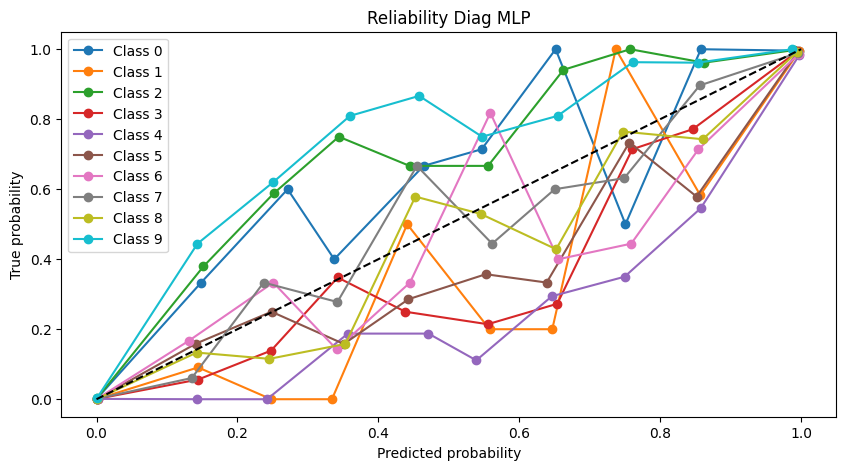

In [41]:
import sklearn.calibration as skcal

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(10):
	probs_mlp = predict(test_loader, model, laplace=False)[:, i]
	(p_true, p_pred) = skcal.calibration_curve(targets == i, probs_mlp, n_bins=10, pos_label=1)

	ax.plot(p_pred, p_true, marker='o', label=f'Class {i}')
ax.plot([0, 1], [0, 1], linestyle='--', color='black')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.set_title('Reliability Diag MLP')
ax.legend()
plt.show()

In [42]:
def expected_calibration_error_classification(title, true_labels, confidences, M=10):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    predicted_labels = []
    # true_labels = []
    # confidences = []
    reliabilities = []

    # get binary class predictions from confidences
    predicted_labels = (confidences >= 0.5)
    # true_labels = torch.cat(true_labels).numpy()
    # confidences = torch.cat(prob).numpy()

    # get a boolean list of correct/false predictions
    accuracies = predicted_labels==true_labels   

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prop_in_bin = in_bin.astype(float).mean()    
             
        if prop_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            bin_accuracy = np.mean(true_labels[in_bin] == 1)
            reliabilities.append(bin_accuracy)
        else:
            reliabilities.append(0.0)  # Avoid division by zero

    # Plot the reliability diagram
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
    plt.plot(np.linspace(0, 1, M), reliabilities, marker="o", linestyle="-", color="blue")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Empirical Accuracy")
    plt.title(f"Reliability Diagram (ECE = {ece[0]:.4f})")
    plt.grid(True)
    plt.savefig(title)
    return ece

array([0.90086376])

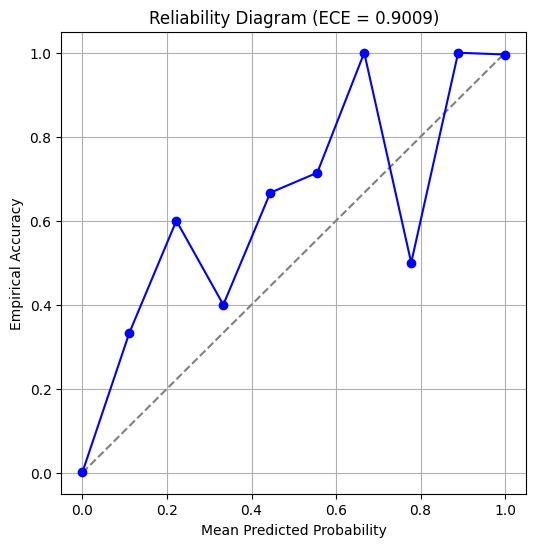

In [40]:
probs_mlp = predict(test_loader, model, laplace=False)[:, 0]
expected_calibration_error_classification("img/Reliability Diagram MLP", targets == 0, probs_mlp)

d:\coding\LotteryTicketPruning\playTest\reliability_diag.py:178: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  


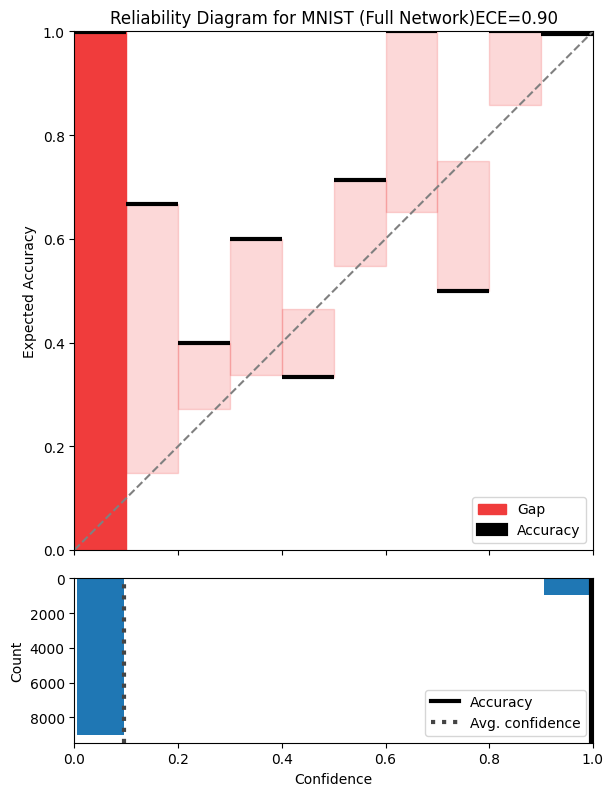

In [36]:
import reliability_diag as rd
import importlib
importlib.reload(rd)

title = "Reliability Diagram for MNIST (Full Network)"

probs_mlp = predict(test_loader, model, laplace=False)[:, 0]
fig = rd.reliability_diagram(
    targets == 0,
    (probs_mlp > 0.5),
    probs_mlp,
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha",
    draw_averages=True, title=title,
    figsize=(6, 6), 
    dpi=100, return_fig=True
    )

In [53]:
class FastTensorDataLoader:
    """
    Source: https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
    and https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors
        self.dataset = tensors[0]

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches

    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

class PermutedMnistGenerator():
    def __init__(self, data_path='./data', num_tasks=10, random_seed=0, download=False):
        self.data_path = data_path
        self.num_tasks = num_tasks
        self.random_seed = random_seed
        self.download = download
        self.out_dim = 10           # number of classes in the MNIST dataset
        self.in_dim = 784           # each image has 28x28 pixels
        self.task_id = 0            # initialize the current task id

    def next_task(self, batch_size=256, val_size=0):
        if self.task_id >= self.num_tasks:
            raise Exception('Number of tasks exceeded!')
        else:
            np.random.seed(self.task_id+self.random_seed)
            perm_inds = np.arange(self.in_dim)

            # First task is (unpermuted) MNIST, subsequent tasks are random permutations of pixels
            if self.task_id > 0:
                np.random.shuffle(perm_inds)

            # make image a tensor and permute pixel values
            tforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.view(-1)[perm_inds]),
            ])

            # load datasets
            train_set = datasets.MNIST(self.data_path, train=True,
                                       transform=tforms, download=self.download)
            val_test_set = datasets.MNIST(self.data_path, train=False,
                                          transform=tforms, download=self.download)

            # fast DataLoader for training
            Xys = [train_set[i] for i in range(len(train_set))]
            Xs = torch.stack([e[0] for e in Xys])
            ys = torch.stack([torch.tensor(e[1]) for e in Xys])
            train_loader = FastTensorDataLoader(Xs, ys, batch_size=batch_size, shuffle=True)
            val_loader, test_loader = val_test_split(val_test_set,
                                                     batch_size=batch_size,
                                                     val_size=val_size,
                                                     num_workers=0)

            # increment task counter
            self.task_id += 1

            if val_size > 0:
                return train_loader, val_loader, test_loader
            return train_loader, test_loader

# Laplace Full network

In [43]:
from laplace import Laplace

# create and train MAP model
def get_model():
    # torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Flatten(), torch.nn.Linear(28*28, 128), torch.nn.ReLU(), torch.nn.Linear(128, 10)
    )

# la_model = get_model().to(device)
la_model = get_model()

# from laplace.utils import ModuleNameSubnetMask
# subnetwork_mask = ModuleNameSubnetMask(model, module_names=['layer.1', 'layer.3'])
# subnetwork_mask.select()
# subnetwork_indices = subnetwork_mask.indices

la = Laplace(la_model, 'classification', subset_of_weights='all', hessian_structure='diag')
la.fit(train_loader)

In [44]:
optimizer = optim.Adam(la_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

train(la_model, train_loader, criterion, optimizer, epochs, device='cpu')

Epoch 1/10, Batch 0/938, Loss: 2.2868053913116455
Epoch 1/10, Batch 100/938, Loss: 0.6051304936408997
Epoch 1/10, Batch 200/938, Loss: 0.3437454104423523
Epoch 1/10, Batch 300/938, Loss: 0.4705201983451843
Epoch 1/10, Batch 400/938, Loss: 0.2768731117248535
Epoch 1/10, Batch 500/938, Loss: 0.3523575961589813
Epoch 1/10, Batch 600/938, Loss: 0.3089933693408966
Epoch 1/10, Batch 700/938, Loss: 0.21821105480194092
Epoch 1/10, Batch 800/938, Loss: 0.17033986747264862
Epoch 1/10, Batch 900/938, Loss: 0.4276469647884369
Epoch 2/10, Batch 0/938, Loss: 0.1987016350030899
Epoch 2/10, Batch 100/938, Loss: 0.09648928046226501
Epoch 2/10, Batch 200/938, Loss: 0.2759166657924652
Epoch 2/10, Batch 300/938, Loss: 0.12528517842292786
Epoch 2/10, Batch 400/938, Loss: 0.2265908122062683
Epoch 2/10, Batch 500/938, Loss: 0.1621859073638916
Epoch 2/10, Batch 600/938, Loss: 0.11789262294769287
Epoch 2/10, Batch 700/938, Loss: 0.12338142096996307
Epoch 2/10, Batch 800/938, Loss: 0.14798031747341156
Epoch 2/1

In [45]:
probs_laplace = predict(test_loader, la_model, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).astype(float).mean()
print(acc_laplace)

0.9733


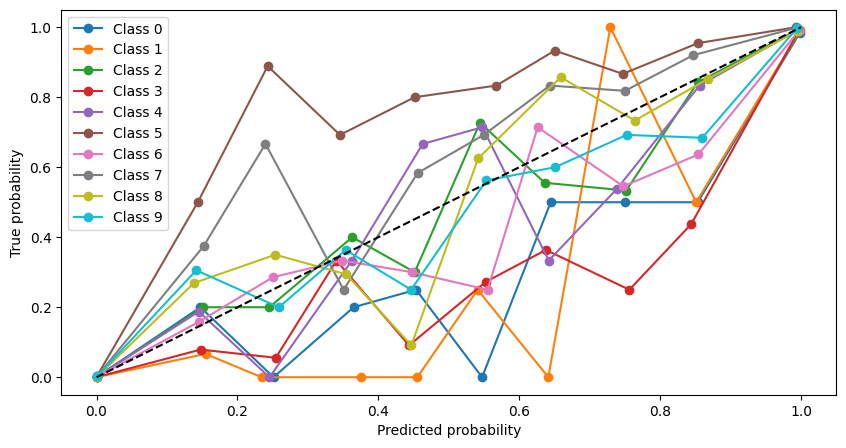

In [29]:
import sklearn.calibration as skcal

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(10):
	probs_laplace = predict(test_loader, la_model, laplace=False)[:, i]
	(p_true, p_pred) = skcal.calibration_curve(targets == i, probs_laplace, n_bins=10)

	ax.plot(p_pred, p_true, marker='o', label=f'Class {i}')
ax.plot([0, 1], [0, 1], linestyle='--', color='black')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.legend()
plt.show()

array([0.90049871])

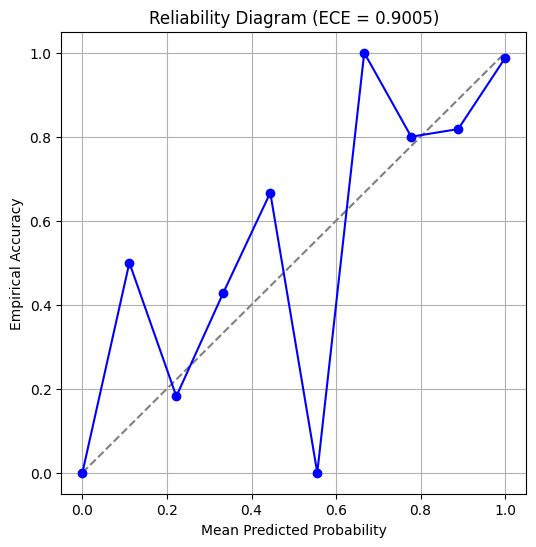

In [49]:
probs_laplace = predict(test_loader, la_model, laplace=False)[:, 0]
expected_calibration_error_classification("img/Reliability Diagram Laplace", targets == 0, probs_laplace)

d:\coding\LotteryTicketPruning\playTest\reliability_diag.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


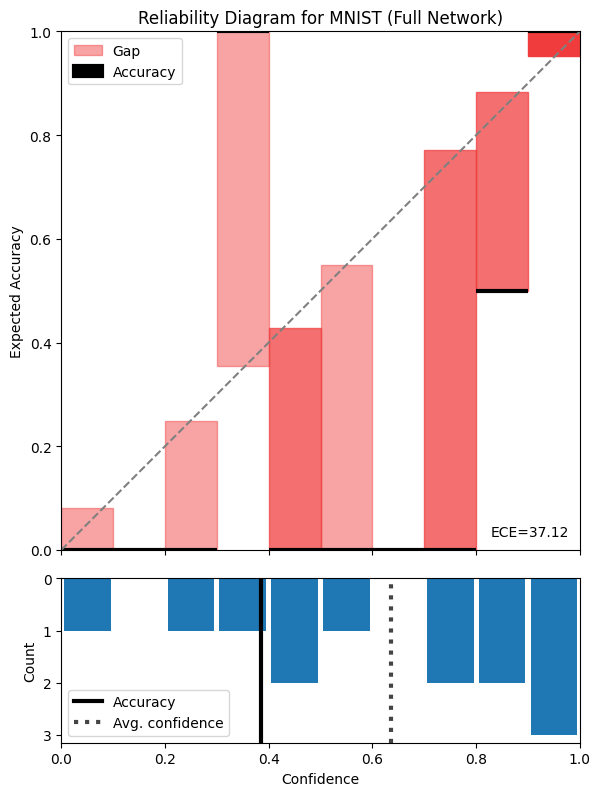

In [67]:
import reliability_diag as rd
import importlib
importlib.reload(rd)

title = "Reliability Diagram for MNIST (Full Network)"

fig = rd.reliability_diagram(
    targets.astype(float),
    probs_laplace.argmax(-1).astype(float),
    np.max(probs_laplace, axis=1).astype(float),
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha",
    draw_averages=True, title=title,
    figsize=(6, 6), 
    dpi=100, return_fig=True
    )

# Subnetwork: Last Layer

In [52]:
from laplace import Laplace

# create and train MAP model
def get_model():
    # torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Flatten(), torch.nn.Linear(28*28, 128), torch.nn.ReLU(), torch.nn.Linear(128, 10)
    )

# la_model = get_model().to(device)
la_model = get_model()

# for name, param in la_model.named_parameters():
# 	print(name, param.shape)

from laplace.utils import ModuleNameSubnetMask
subnetwork_mask = ModuleNameSubnetMask(la_model, module_names=['3'])
subnetwork_mask.select()
subnetwork_indices = subnetwork_mask.indices

la = Laplace(la_model, 'classification', subset_of_weights='subnetwork', hessian_structure='full', subnetwork_indices=subnetwork_indices)
la.fit(train_loader)

In [53]:
optimizer = optim.Adam(la_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

train(la_model, train_loader, criterion, optimizer, epochs, device='cpu')

Epoch 1/10, Batch 0/938, Loss: 2.2826039791107178
Epoch 1/10, Batch 100/938, Loss: 0.6248272061347961
Epoch 1/10, Batch 200/938, Loss: 0.5132859945297241
Epoch 1/10, Batch 300/938, Loss: 0.34176817536354065
Epoch 1/10, Batch 400/938, Loss: 0.3316632807254791
Epoch 1/10, Batch 500/938, Loss: 0.18958383798599243
Epoch 1/10, Batch 600/938, Loss: 0.187839537858963
Epoch 1/10, Batch 700/938, Loss: 0.19638942182064056
Epoch 1/10, Batch 800/938, Loss: 0.28398463129997253
Epoch 1/10, Batch 900/938, Loss: 0.2994529604911804
Epoch 2/10, Batch 0/938, Loss: 0.2646695375442505
Epoch 2/10, Batch 100/938, Loss: 0.22320476174354553
Epoch 2/10, Batch 200/938, Loss: 0.1993323415517807
Epoch 2/10, Batch 300/938, Loss: 0.1520427018404007
Epoch 2/10, Batch 400/938, Loss: 0.15656176209449768
Epoch 2/10, Batch 500/938, Loss: 0.15286029875278473
Epoch 2/10, Batch 600/938, Loss: 0.2637086808681488
Epoch 2/10, Batch 700/938, Loss: 0.14281263947486877
Epoch 2/10, Batch 800/938, Loss: 0.1990567296743393
Epoch 2/1

In [54]:
probs_laplace = predict(test_loader, la_model, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).astype(float).mean()
print(acc_laplace)

0.9731


array([0.90068994])

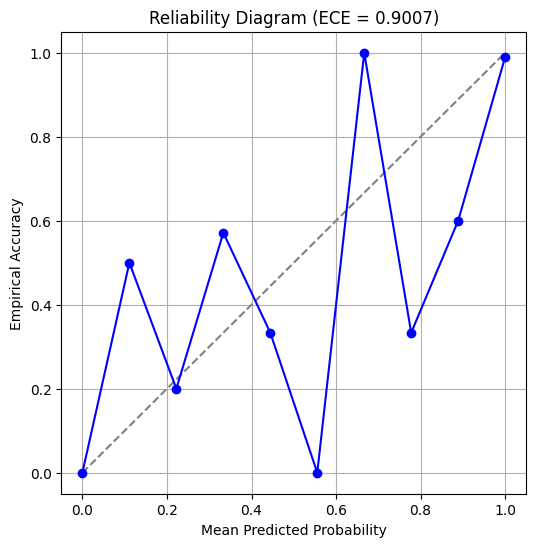

In [55]:
probs_laplace = predict(test_loader, la_model, laplace=False)[:, 0]
expected_calibration_error_classification("img/Reliability Diagram Laplace(subnetwork)", targets == 0, probs_laplace)

d:\coding\LotteryTicketPruning\playTest\reliability_diag.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


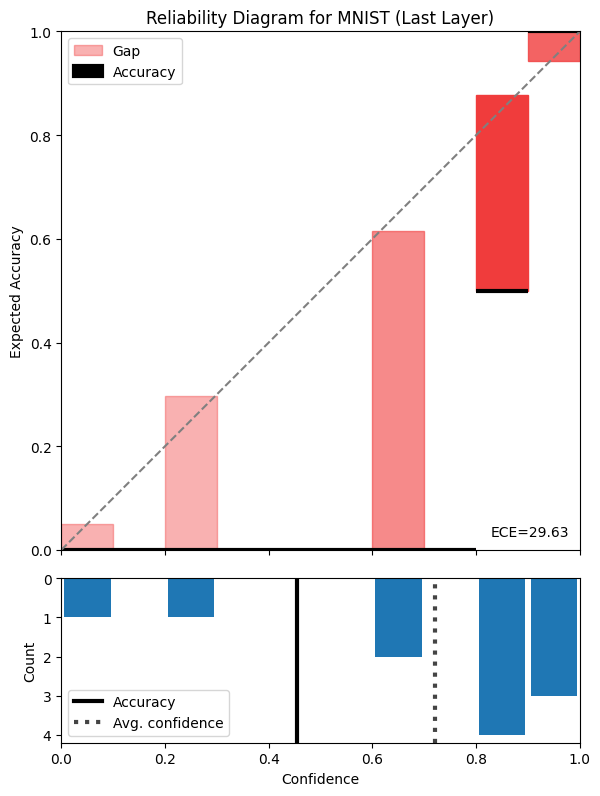

In [63]:
import reliability_diag as rd
import importlib
importlib.reload(rd)

title = "Reliability Diagram for MNIST (Last Layer)"

fig = rd.reliability_diagram(
    targets.astype(float),
    probs_laplace.argmax(-1).astype(float),
    np.max(probs_laplace, axis=1).astype(float),
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha",
    draw_averages=True, title=title,
    figsize=(6, 6), 
    dpi=100, return_fig=True
    )

In [54]:
np.max(probs_laplace, axis=1).astype(float)
# probs_laplace.argmax(-1).astype(float)

array([ 9.48554325, 11.09114456,  6.67536736, ..., 14.51783562,
       12.97873592, 14.2789917 ])